#  import library and pre_train model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/My Drive/flick_dataset_preprocessing"

/content/gdrive/My Drive/flick_dataset_preprocessing


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import json
import glob
import shutil
import os

In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

#create model

In [ ]:
img_width, img_height = 32,32

In [ ]:
model_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3))

for layer in model.layers:
    layer.trainable = False

In [ ]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
output = Dense(10, activation="softmax")(x)

In [ ]:
model_resnet = Model(inputs = model.input, outputs = output)

In [ ]:
model_resnet.compile(loss = "categorical_crossentropy", 
                    optimizer = "adam", 
                    metrics=["accuracy"],
                     )

In [ ]:
model.summary()

# read data from piclke file

In [ ]:
def read_data():
    with open("logo_dataset.pickle", 'rb') as f:
        save = pickle.load(f)
        X = save['train_dataset']       # assign X as train dataset
        Y = save['train_labels']        # assign Y as train labels 
        X_test = save['test_dataset']   # assign X_test as test dataset
        Y_test = save['test_labels']    #assign Y_test as test labels
        del save
    return [X, X_test], [Y, Y_test]

def reformat(dataset, labels):   
    dataset = dataset.reshape((-1, 32, 32,3)).astype(np.float32)    # Reformatting shape array to give a scalar value for dataset.  
    labels = (np.arange(10) == labels[:, None]).astype(np.float32) 
    return dataset, labels

dataset, labels = read_data()
X,Y = reformat(dataset[0], labels[0])
X_test, Y_test = reformat(dataset[1], labels[1])
print('Training set', X.shape, Y.shape)
print('Test set', X_test.shape, Y_test.shape)            

# Shuffle the data
X, Y = shuffle(X, Y)    # Imported from TFLearn.

Training set (70000, 32, 32, 3) (70000, 10)
Test set (7000, 32, 32, 3) (7000, 10)


# train model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callback = [EarlyStopping(monitor = "val_loss",patience=5),
            ModelCheckpoint("check_point.h5",save_best_only= True)]

In [ ]:
history = model.fit(X,Y,
                epochs=12,

               validation_data=(X_test, Y_test),
                batch_size=128
               # callbacks = [callback]
               )

Train on 70000 samples, validate on 7000 samples
Epoch 1/12
70000/70000 [==============================] - 283s 4ms/sample - loss: 0.2531 - acc: 0.9199 - val_loss: 0.0651 - val_acc: 0.9817
Epoch 2/12
70000/70000 [==============================] - 310s 4ms/sample - loss: 0.0438 - acc: 0.9868 - val_loss: 0.0200 - val_acc: 0.9940
Epoch 3/12
70000/70000 [==============================] - 305s 4ms/sample - loss: 0.0270 - acc: 0.9918 - val_loss: 0.0152 - val_acc: 0.9944
Epoch 4/12
70000/70000 [==============================] - 317s 5ms/sample - loss: 0.0218 - acc: 0.9934 - val_loss: 0.0218 - val_acc: 0.9949
Epoch 5/12
70000/70000 [==============================] - 310s 4ms/sample - loss: 0.0192 - acc: 0.9943 - val_loss: 0.0173 - val_acc: 0.9964
Epoch 6/12
70000/70000 [==============================] - 313s 4ms/sample - loss: 0.0177 - acc: 0.9951 - val_loss: 0.0137 - val_acc: 0.9963
Epoch 7/12
70000/70000 [==============================] - 317s 5ms/sample - loss: 0.0158 - acc: 0.9952 - val_lo

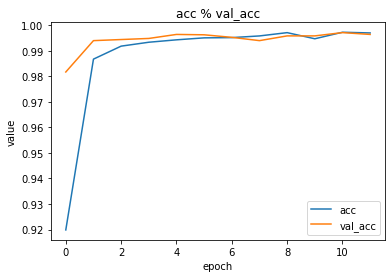

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.xlabel("epoch")
plt.ylabel("value")
plt.title("acc % val_acc")
plt.legend(["acc","val_acc"])
plt.show()

# tạo confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(Y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

In [ ]:
from collections import OrderedDict
import itertools

In [ ]:
genres = {'Apple': 0, 'BMW': 1, 'Heineken': 2, 'HP': 3, 'Intel': 4, 
          'Mini': 5, 'Starbucks': 6, 'Vodafone': 7, 'unknown': 8, 'Ferrari': 9}

Normalized confusion matrix


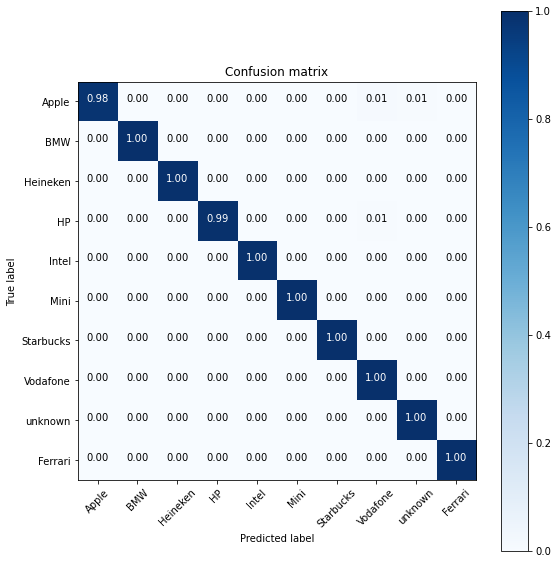

In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

# save model

In [ ]:
model_resnet.save("model_resnet_dataset8.h5")